# Sampyo

1. classification model
2. 7class
3. 2.5% + 5%

## Import module

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import random

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcublas.so.10.0: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

## train data / test data

In [2]:
dataset_name = "./crop_dataset_water"

x_train = []
y_train = []
x_test = []
y_test = []

folder_list = os.listdir(dataset_name)
folder_list.sort()

for one_folder in folder_list:
    splited_one_folder =  one_folder.split("_")
    eveloped_one_folder = splited_one_folder[0]+"_"+splited_one_folder[1]
    print(one_folder)
    
    join_folder_path = os.path.join(dataset_name, one_folder)
    data_list = os.listdir(join_folder_path)
    
    ## train / test = 8:2
    test_list = random.sample(data_list, int(len(data_list) * 0.2))

    for one_data in data_list:
        
        join_data_path = os.path.join(join_folder_path, one_data)
        
        ### imread / resize / normalize
        img = cv2.imread(join_data_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (512,512))
        img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img = np.reshape(img, (512,512,1))

        # train
        if not one_data in test_list:
            x_train.append(img)
            y_train.append(eveloped_one_folder)
            
        elif one_data in test_list:
            x_test.append(img)
            y_test.append(eveloped_one_folder)

            
tmp = [[x,y] for x,y in zip(x_train, y_train)]
random.shuffle(tmp)

x_train = [n[0] for n in tmp]
y_train = [n[1] for n in tmp]
            
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)  
y_test = np.array(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

FM_2.4_2.5%
FM_2.4_5%
FM_2.6_2.5%
FM_2.6_5%
FM_2.8_2.5%
FM_2.8_5%
FM_3.0_2.5%
FM_3.0_5%
FM_3.2_2.5%
FM_3.2_5%
FM_3.4_2.5%
FM_3.4_5%
FM_3.61_2.5%
FM_3.61_5%
(9348, 512, 512, 1)
(9348,)
(2333, 512, 512, 1)
(2333,)


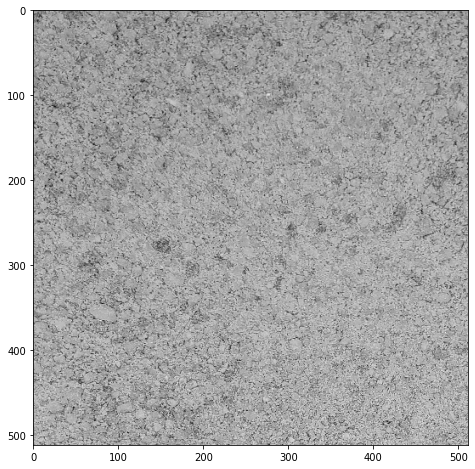

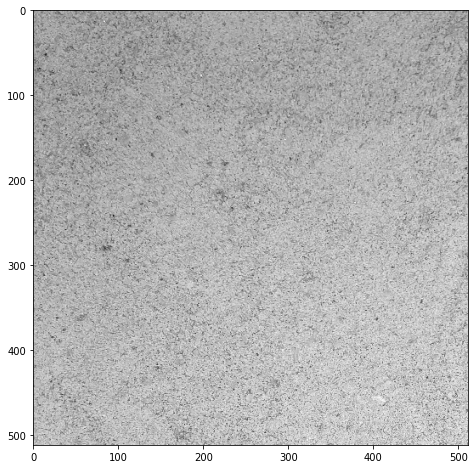

In [3]:
plt.figure(figsize=(8,8))
plt.imshow(x_train[0].reshape(512,512), cmap="gray")

plt.figure(figsize=(8,8))
plt.imshow(x_test[0].reshape(512,512), cmap="gray")

## Y data onehot encoding

* ex1) 2 -> [1,0,0,0,0,0]
* ex2) 7 -> [0,0,0,0,0,1]

In [4]:
from sklearn.preprocessing import OneHotEncoder

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

enc = OneHotEncoder()
enc.fit(y_train)

y_train_onehot = enc.transform(y_train).toarray()
y_test_onehot = enc.transform(y_test).toarray()

print(y_test_onehot)
print(y_test)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[['FM_2.4']
 ['FM_2.4']
 ['FM_2.4']
 ...
 ['FM_3.61']
 ['FM_3.61']
 ['FM_3.61']]


## Import keras module

In [5]:
import keras

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization

from keras.utils import multi_gpu_model

from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cai/anaconda3/envs/MRCNN/l

## Deep Learning Model

In [6]:
inputs = Input((512, 512, 1))

# Layer 1
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(inputs)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 2
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 3
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 4
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 5
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 6
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 7
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = 'relu',kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

x = Flatten()(x)
x = Dense(128, activation = 'relu',kernel_initializer="glorot_normal")(x)
x = Dense(64, activation = 'relu',kernel_initializer="glorot_normal")(x)
outputs = Dense(7, activation = 'softmax',kernel_initializer="glorot_normal")(x)

model = Model(inputs=[inputs], outputs=[outputs])

#model.summary()
# keras.utils.vis_utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# from IPython.display import Image
# Image("model_plot.png")

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 128)     1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 128)     147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 128)     0         
__________

## Learning

In [4]:
parallel_model = multi_gpu_model(model,gpus=2)

# callback
# early_stopping = EarlyStopping(monitor='val_loss',patience = 30)

# optimizer
adam = keras.optimizers.Adam(lr=0.00001)
parallel_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# fit model
hist = parallel_model.fit(x_train, y_train_onehot,\
                          epochs=10, batch_size=4,\
                          validation_data=(x_test, y_test_onehot))

# plot loss & val_loss
plt.figure(figsize=(10,4))
plt.plot(hist.history['loss'],'b',label='loss')
plt.plot(hist.history['val_loss'],'r',label='val_loss')
plt.legend(loc="upper right");

NameError: name 'multi_gpu_model' is not defined

# re train(only you need)

In [ ]:
hist = parallel_model.fit(x_train, y_train_onehot,\
                          epochs=1, batch_size=4,\
                          validation_data=(x_test, y_test_onehot))

# plot loss & val_loss
plt.figure(figsize=(10,4))
plt.plot(hist.history['loss'],'b',label='loss')
plt.plot(hist.history['val_loss'],'r',label='val_loss')
plt.legend(loc="upper right");

## Predict

In [9]:
pred_y = model.predict(x_test)
pred_y = np.argmax(pred_y,axis = 1)
real_y = np.argmax(y_test_onehot, axis = 1)

print(pred_y)
print(real_y)

[0 0 0 ... 6 1 1]
[0 0 0 ... 6 6 6]


In [10]:
corr_num1 = 0
corr_num2 = 0
for i in range(real_y.shape[0]):
    if pred_y[i] == real_y[i]:
        corr_num1 += 1
        
    if abs(int(pred_y[i]) - int(real_y[i])) <= 1:
        corr_num2 += 1
        
print(corr_num1 / real_y.shape[0] * 100, "%")
print(corr_num2 / real_y.shape[0] * 100, "%")

31.84740677239606 %
50.70724389198457 %


## Confusion Matrix

In [11]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(pred_y, real_y)

['2.4', '2.6', '2.8', '3.0', '3.2', '3.4', '3.61']


<AxesSubplot:>

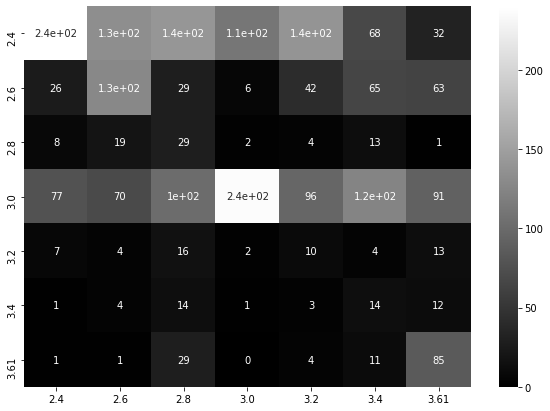

In [23]:
import seaborn as sn
import pandas as pd


cm_list = []
for one_folder in folder_list:
    splited_folder = one_folder.split("_")
    cm_list.append(splited_folder[1])
    cm_list = set(cm_list)
    cm_list = list(cm_list)
    cm_list.sort()
print(cm_list)
df_cm = pd.DataFrame(conf_mat, index = [i for i in cm_list],
                  columns = [i for i in cm_list])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="gray")

<AxesSubplot:>

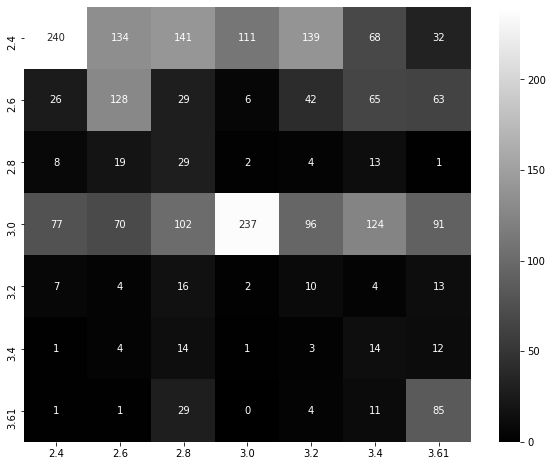

In [24]:
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True, cmap="gray", fmt="g")

In [ ]:
model.save("./save_model/model_1.h5")